In [892]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_squared_log_error

from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from flaml import AutoML


In [893]:
from pandas.io.parsers import read_csv

df = read_csv("insurance.csv")

In [894]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [895]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [896]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [897]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [898]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<AxesSubplot:>

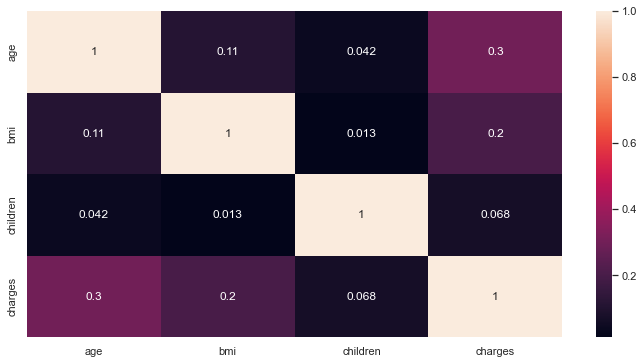

In [899]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

<AxesSubplot:xlabel='bmi', ylabel='Count'>

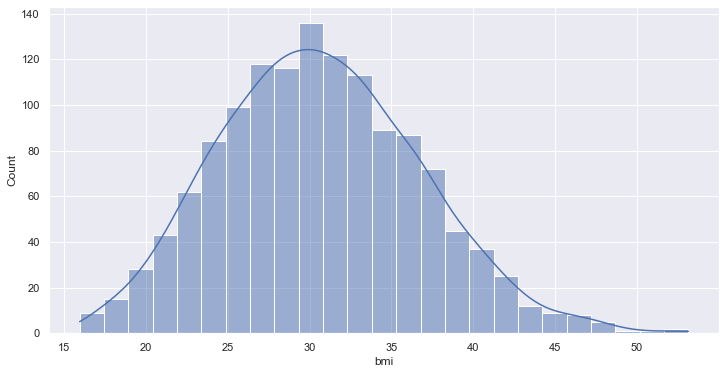

In [900]:
# Bmi(Vücut Kitle İndeksi)’nin dağılımını inceleyiniz.

plt.figure(figsize=(12,6))
sns.set_theme()
sns.histplot(df,x="bmi",kde=True)

<AxesSubplot:xlabel='smoker', ylabel='charges'>

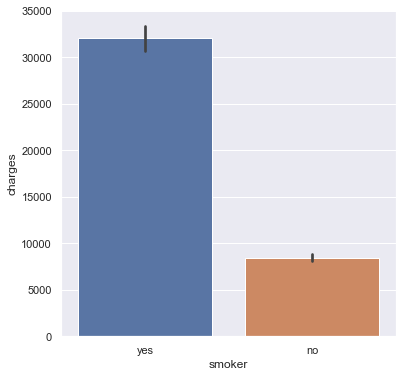

In [901]:
# “smoker” ile “charges” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(6,6))
sns.barplot(x="smoker",y="charges",data=df)

In [902]:
df[["smoker","charges"]].groupby(["smoker"]).mean()

,charges
smoker,
no,8434.268298
yes,32050.231832


<AxesSubplot:xlabel='region', ylabel='count'>

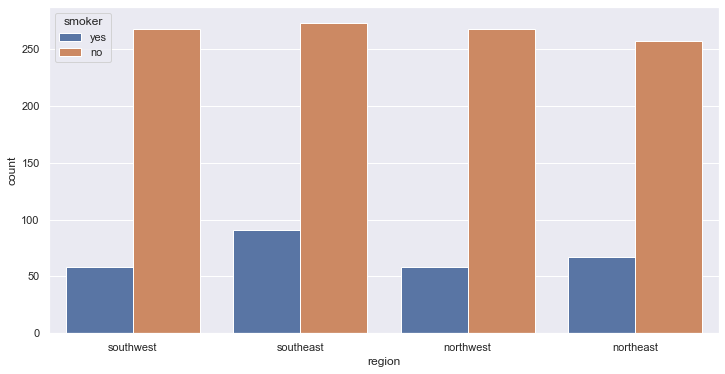

In [903]:
# “smoker” (Sigara tüketen) ile “region”(Bölge) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.countplot(x="region",data=df,hue="smoker")

In [904]:
df[df["smoker"]=="no"][["smoker","region"]].groupby(["region"]).count()

,smoker
region,
northeast,257
northwest,267
southeast,273
southwest,267


In [905]:
df[df["smoker"]=="yes"][["smoker","region"]].groupby(["region"]).count()

,smoker
region,
northeast,67
northwest,58
southeast,91
southwest,58


In [906]:
df[["smoker","region"]].value_counts()

smoker  region   
no      southeast    273
        northwest    267
        southwest    267
        northeast    257
yes     southeast     91
        northeast     67
        northwest     58
        southwest     58
dtype: int64

<AxesSubplot:xlabel='sex', ylabel='bmi'>

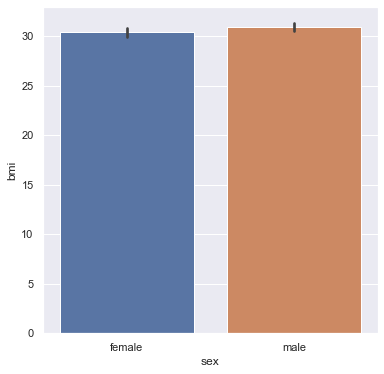

In [907]:
# “bmi” ile “sex”(Cinsiyet) arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(6,6))
sns.barplot(x="sex",y="bmi",data=df)


In [908]:
df[["smoker","sex"]].groupby(["sex"]).mean()

""
sex
female
male


In [909]:
# En çok “children”’a sahip “region”’ı bulunuz.

df[["children","region"]].value_counts().describe()


count     24.000000
mean      55.750000
std       49.214924
min        1.000000
25%        7.000000
50%       48.500000
75%       77.250000
max      157.000000
dtype: float64

<AxesSubplot:xlabel='bmi', ylabel='age'>

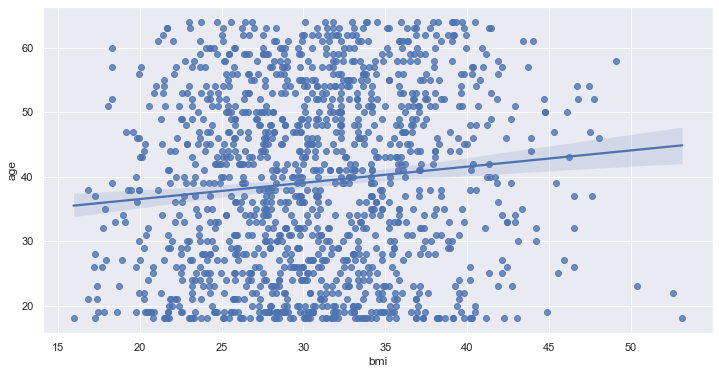

In [910]:
# “Age” ile “bmi” arasındaki ilişkiyi inceleyiniz.
plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="age",data=df)

<AxesSubplot:xlabel='bmi', ylabel='children'>

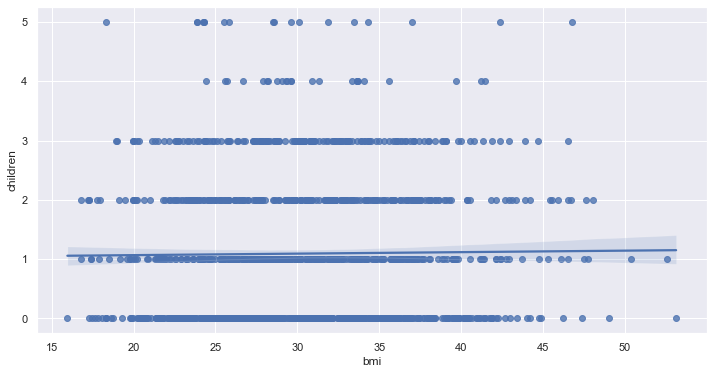

In [911]:
# “bmi” ile “children” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="children",data=df)

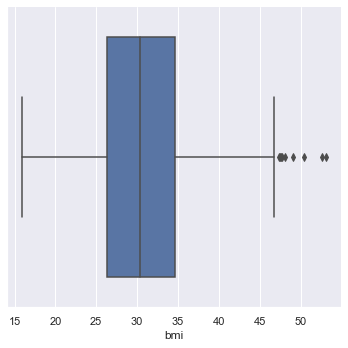

In [912]:
# “bmi” değişkeninde outlier var mıdır? İnceleyiniz.

sns.catplot(x="bmi",data=df,kind="box")

<AxesSubplot:xlabel='bmi', ylabel='charges'>

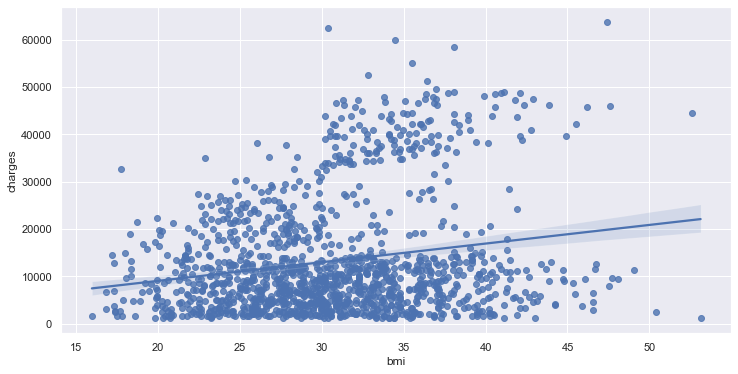

In [913]:
# “bmi” ile “charges” arasındaki ilişkiyi inceleyiniz.

plt.figure(figsize=(12,6))
sns.regplot(x="bmi",y="charges",data=df)

<AxesSubplot:xlabel='region', ylabel='bmi'>

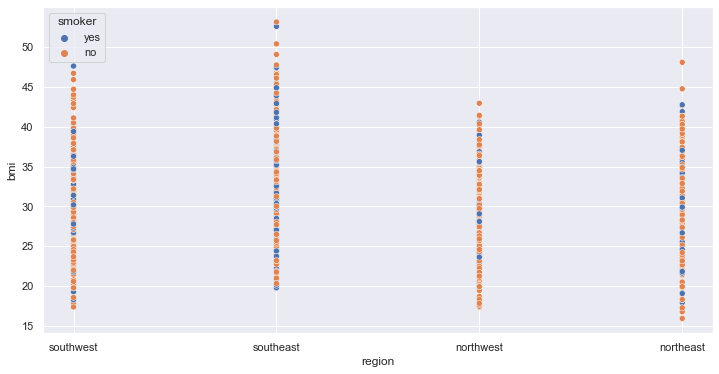

In [914]:
# “region”, “smoker” ve “bmi” arasındaki ilişkiyi bar plot kullanarak inceleyiniz.

plt.figure(figsize=(12,6))
sns.set_theme()
sns.scatterplot(data = df,x="region",y="bmi",hue="smoker")

In [915]:
num_cols=df._get_numeric_data().columns.tolist()

In [916]:
num_cols

['age', 'bmi', 'children', 'charges']

4. Veri Ön İşleme Yapılması

In [917]:

df.loc[df["sex"]=="male","sex"] = 0
df.loc[df["sex"]=="female","sex"] = 1

df.loc[df["smoker"]=="no","smoker"] = 0
df.loc[df["smoker"]=="yes","smoker"] = 1

df.loc[df["region"]=="northwest","region"] = 0
df.loc[df["region"]=="northeast","region"] = 1
df.loc[df["region"]=="southwest","region"] = 2
df.loc[df["region"]=="southeast","region"] = 3


In [918]:

df = df.astype({"sex":"category"})
df = df.astype({"smoker":"category"})
df = df.astype({"region":"category"})


Outlier Detection

<AxesSubplot:xlabel='charges', ylabel='bmi'>

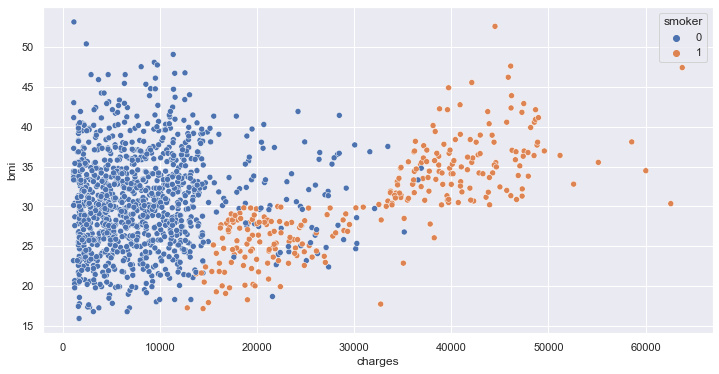

In [919]:
plt.figure(figsize=(12,6))
sns.set_theme()
sns.scatterplot(data = df,x="charges",y="bmi",hue="smoker")

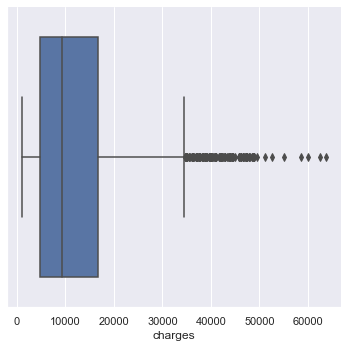

In [920]:
sns.catplot(x="charges",data=df,kind="box")

In [921]:
chargesdf = df[["charges","smoker"]].groupby(["smoker"])
chargesdf.describe()

charges                                                        \
         count          mean           std         min           25%   
smoker                                                                 
0       1064.0   8434.268298   5993.781819   1121.8739   3986.438700   
1        274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                                                
                50%           75%          max  
smoker                                          
0        7345.40530  11362.887050  36910.60803  
1       34456.34845  41019.207275  63770.42801

In [922]:
nonSmokerQ1 = 0
nonSmokerQ3 = 20000

smokerQ1 = 0
smokerQ3 = 50000



In [923]:
nonSmokerOut = df[(df["smoker"]==0)&(df["charges"]<nonSmokerQ1)|((df["smoker"]==0)&(df["charges"]>nonSmokerQ3))].index

In [924]:
smokerOut = df[(df["smoker"]==1)&(df["charges"]<smokerQ1)|((df["smoker"]==1)&(df["charges"]>smokerQ3))].index

In [925]:
df.drop(index=nonSmokerOut,inplace=True)
df.drop(index=smokerOut,inplace=True)


In [926]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.90,0,1,2,16884.9240
1,18,0,33.77,1,0,3,1725.5523
2,28,0,33.00,3,0,3,4449.4620
4,32,0,28.88,0,0,0,3866.8552
5,31,1,25.74,0,0,3,3756.6216
...,...,...,...,...,...,...,...
1333,50,0,30.97,3,0,0,10600.5483
1334,18,1,31.92,0,0,1,2205.9808
1335,18,1,36.85,0,0,3,1629.8335
1336,21,1,25.80,0,0,2,2007.9450


5. Model Seçme

In [927]:
x = df.drop(["charges"],axis=1)
y = df["charges"]

In [928]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=200)

In [929]:
models = []

models.append(("Linear",LinearRegression()))
models.append(("Lasso",Lasso()))
models.append(("Ridge",Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandomForests', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))

In [930]:
for name,model in models:
    mod = model.fit(X_train,Y_train)
    predictions= mod.predict(X_test)

    score = mod.score(x,y)
    mse = mean_squared_error(Y_test,predictions)
    mae = mean_absolute_error(Y_test,predictions)
    mape = mean_absolute_percentage_error(Y_test,predictions)   
    rmse = np.sqrt(mean_squared_error(Y_test,predictions))
    # rmsle = mean_squared_log_error(Y_test,predictions) # Negatif değerler için kullanılmazmış
    print(name,score,mse,mae,mape,rmse)
    

Linear 0.8384688982884743 23523244.20574803 3547.2272889533056 0.4518586833265514 4850.076721635239
Lasso 0.8384713856958681 23521522.75856178 3546.9946501975674 0.4518213426627833 4849.899252413577
Ridge 0.8384116652881419 23548093.443827845 3552.657398041245 0.4525546979575076 4852.637782055018
KNN 0.3563329850015653 123497946.02230571 7435.50434640945 1.0922956982154746 11112.962972236779
SVR -0.0881169934639503 152478672.85941806 7937.44335191505 1.0777071478861109 12348.225494354161
CART 0.9749914034902154 16486769.01744117 1696.957838484252 0.2236072014176505 4060.3902543279223
RandomForests 0.9809503182919309 9316224.56662801 1372.0092082810834 0.18865016447905125 3052.2490997014
GradientBoosting 0.9675099698255734 8102699.593074827 1232.68359708868 0.17043947245832508 2846.524124801128


6. Hiper-parametre Optimizasyonu

In [931]:
#automl = AutoML()

#automl.fit(X_train, Y_train, task="regression",metric="rmse",time_budget=240)

In [932]:
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

#from warnings import filterwarnings
#filterwarnings('ignore')

In [933]:
#model = LGBMRegressor(**automl.best_config)
#model.fit(X_train,Y_train)

In [934]:
model = LGBMRegressor(colsample_bytree=0.9879551787309777,
              learning_rate=0.1407942810321496, log_max_bin=10,
              min_child_samples=33, n_estimators=28, num_leaves=8,
              reg_alpha=0.0009765625, reg_lambda=0.7969736155439798).fit(X_train,Y_train)
pred = model.predict(X_test)
mean_squared_error(Y_test,pred,squared=False)

[LightGBM] [Warning] Unknown parameter: log_max_bin


2981.8915434108353